In [1]:
import numpy as np

from os import path
from tqdm import tqdm_notebook
from matplotlib import pyplot as plot
from bids import BIDSLayout
import os s
import glob

import pandas as ps

import itertools

from scipy.stats import pearsonr
from cloudpickle import load

from scipy.io import loadmat
from re import split, findall

import seaborn as sns
    

from matplotlib.ticker import ScalarFormatter



In [2]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [3]:
def _get_meta(path_subject, file_type):
    return glob.glob(path_subject+'/*'+file_type+'*')[0]

def bootstrap_ci(data, n=100, axis=0, percentiles=(2.5,97.5)):
   
    bootstraps = np.ndarray((n,data.shape[1]), dtype = data.dtype)
    # permute axis to have the one to work on as axis=0
    #data = np.moveaxis(data,axis,0)

    for idx in range(n):
        perm_indices = np.random.randint(0, data.shape[0], data.shape[0])
        bootstraps[idx,:] = data[perm_indices,:].mean(axis=0)
    
    ci = np.squeeze(np.percentile(bootstraps, percentiles, keepdims=True, axis=0))

    return ci[0,:], ci[1,:]

def morph_to_parcel(data, mOp, surr, mask, n_parcel=100):
    n_chans, n_ts = data.shape[1:]
    # data is assumed to be a connectivity matrix 
    if np.diff(data.shape[1:]) > 0:
        raise ValueError('data supposed to be square matrix of ch x ch dimension')
    
    if mOp.shape[:2] != data.shape[1:]:
        raise ValueError('data and mOp shoud have the same dimension')
    
    n_freqs = data.shape[0]

    plv_morphed = np.zeros((n_freqs, n_parcel, n_parcel), dtype=float)
    iplv_morphed = np.zeros((n_freqs, n_parcel, n_parcel), dtype=float)
    edge_size = np.zeros((n_freqs, n_parcel, n_parcel), dtype=int)
    frac_sign_plv = np.zeros((n_freqs, n_parcel, n_parcel), dtype=float)
    frac_sign_iplv = np.zeros((n_freqs, n_parcel, n_parcel), dtype=float)
        
    sur_lev_plv = np.mean(np.abs(surr), axis=(1,2))*3.42 ## p<0.001
    sur_lev_iplv = np.std(np.abs(surr), axis=(1,2))*3.59 ## p<0.001
                
    for i in range(n_chans):
        for j in range(i+1, n_chans):
            
            x, y = mOp[i,j]
            
            if x>= 0 and y>= 0 and (mask[i,j] == True) \
                and (np.all(np.abs(data[:, i, j]) > 0)) \
                and (np.all(np.abs(data[-18:, i, j]) <= 0.25)):

                    plv_morphed[:,x,y] += np.abs(data[:, i, j])
                    iplv_morphed[:,x,y] += np.abs(np.imag(data[:, i, j]))
                    edge_size[:,x,y] += 1
                    frac_sign_plv[:,x,y] += (np.abs(data[:, i, j]) >= sur_lev_plv)
                    frac_sign_iplv[:,x,y] += (np.abs(np.imag(data[:, i, j])) >= sur_lev_iplv)
                    
                    if x!=y: 
                        plv_morphed[:,y,x] += np.abs(data[:, i, j])
                        iplv_morphed[:,y,x] += np.abs(np.imag(data[:, i, j]))
                        edge_size[:,y,x] += 1
                        frac_sign_plv[:,y,x] += (np.abs(data[:, i, j]) >= sur_lev_plv)
                        frac_sign_iplv[:,y,x] += (np.abs(np.imag(data[:, i, j])) >= sur_lev_iplv)
                    
    correction = edge_size.copy()
    correction[edge_size == 0] = 1 # prevent division by 0
   
    return plv_morphed / correction, iplv_morphed / correction, edge_size, frac_sign_plv / correction, frac_sign_iplv / correction
    

def create_second_order_ref_mask(channel_names):

    second_order_mask = np.ones((len(channel_names), len(channel_names)), dtype=bool)
    
    for i, ch_i in enumerate(channel_names):
        for j, ch_j in enumerate(channel_names):
            # extract reference label
            ref_name_i = ch_i.split('-')[-1]
            ref_name_j = ch_j.split('-')[-1]
            
            ref_letter_i = split('[0-9]+',ref_name_i)
            ref_number_i = int(findall('\d+',ref_name_i)[0])
            
            ref_letter_j = split('[0-9]+',ref_name_j)
            ref_number_j = int(findall('\d+',ref_name_j)[0] )
            
            # if reference in both channels have the same letter and 
            # are neighboring contacts remove them
            if ref_letter_i == ref_letter_j and np.abs(ref_number_i-ref_number_j) == 1:
                second_order_mask[i,j] = False
                
    return second_order_mask

## Init pipeline

In [4]:
subjects = ['%.02d' % idx for idx in range(1,69)]
n_subjects = len(subjects)
n_parcels = 107 #Yeo 7 105 parcels + 2 
#n_parcels = 193 #Schafer 100 191 parcels + 2
n_freqs = 50

# pre-alloc
group_morphed_plv = np.zeros((n_freqs, n_parcels,n_parcels,n_subjects), dtype=float)
group_morphed_iplv = np.zeros((n_freqs, n_parcels,n_parcels,n_subjects), dtype=float)
group_morphed_k_plv = np.zeros((n_freqs, n_parcels,n_parcels,n_subjects), dtype=float)
group_morphed_k_iplv = np.zeros((n_freqs, n_parcels,n_parcels,n_subjects), dtype=float)
group_edge_counts = np.zeros((n_freqs, n_parcels,n_parcels,n_subjects), dtype=float)

subjects.remove('57')
subjects.remove('18') # dimension mismatch cplv and montage info 

In [5]:
nidx = 0
second_order_group = list()
mOp_collector = list()
for sidx, subject in enumerate(tqdm_notebook(subjects,total=len(subjects))):
    der_path = '/home/gabri/localdata/rest-bids/derivatives/crosspy/plv_spectrum_cw_wake/'
    ####THIS CODE NOW PRODUCES PLV = |cPLV| only data####
    subj_string = 'sub-'+subject
    base_path = '/home/gabri/localdata/rest-bids/'+subj_string+'/ses-01/ieeg/'
    fnames = glob.glob(os.path.join(der_path,'*'+subj_string+'*with_lp.pickle'))
    sidx = int(subject)-1
    
    if len(fnames) > 0:

        plv_spectrum_dict = np.load(fnames[0], allow_pickle=True)
        
        tmp_plv_spectrum = plv_spectrum_dict['cplv_spectrum']
        plv_spectrum_mask = plv_spectrum_dict['reference_mask']
        tmp_plv_spectrum_surr = plv_spectrum_dict['surrogate_spectrum']
        
        frequencies = plv_spectrum_dict['frequencies']
        plv_spectrum = (np.stack((tmp_plv_spectrum, tmp_plv_spectrum_surr), axis=3))
        
        # read meta information and ez tagging
        meta_fname = _get_meta(os.path.join(base_path), 'meta.csv')
        meta = ps.read_csv(meta_fname, delimiter=',')

        ez_tags = np.array(meta.EZ)
        nez_tags = (ez_tags  == 0).astype(int)
        nez_mask = np.dot(nez_tags[:,np.newaxis],nez_tags[:,np.newaxis].T)
        
        #read montage for channel names
        montage_fname = _get_meta(os.path.join(base_path), 'montage.tcsv')
        montage = ps.read_csv(montage_fname, delimiter='\t')
        
        elec_pos = _get_meta(os.path.join(base_path), 'electrodes.tcsv')
        elec_pos = ps.read_csv(elec_pos, delimiter='\t')
        # *_par-parc2018yeo7_400_mOp.npy
        # *yeo7_mOp.npy
        mOp_fname = glob.glob(os.path.join(base_path,'*_par-yeo7_mOp.npy'))

        # read the morphing operators
        with open(mOp_fname[0],'rb') as f:
            mOp_dict = load(f)
            
        mOp = mOp_dict['mOp']
        n_channels = mOp.shape[0]
        mOp_collector.append(mOp.flatten())
        second_order_mask = create_second_order_ref_mask(montage.name.tolist())
        
        # find missing channels if any
        indices = [idx for idx, name in enumerate(montage.name) if elec_pos[elec_pos.name == name.split('-')[0]].empty]
        
        if len(indices) > 0:
            plv_spectrum = np.delete(plv_spectrum, indices, axis=1)
            plv_spectrum = np.delete(plv_spectrum, indices, axis=2)
            
            nez_mask = np.delete(nez_mask, indices, axis=0)
            nez_mask = np.delete(nez_mask, indices, axis=1)
            
            plv_spectrum_mask = np.delete(plv_spectrum_mask, indices, axis=0)
            plv_spectrum_mask = np.delete(plv_spectrum_mask, indices, axis=1)
                                                         
            second_order_mask = np.delete(second_order_mask, indices, axis=0)
            second_order_mask = np.delete(second_order_mask, indices, axis=1)
                                                         
        # let's sanity check array size dim which shuold be identical if not rise an error
        if mOp.shape[0] == plv_spectrum.shape[1]:
            
            mask = np.logical_and(plv_spectrum_mask.astype(bool), 
                                  nez_mask.astype(bool))
            #mask = np.logical_and(mask, second_order_mask)

            morphed_plv, morphed_iplv, size_obs, k_plv, k_iplv = morph_to_parcel(np.squeeze(plv_spectrum[:,:,:,0]), mOp, 
                                                       np.squeeze(plv_spectrum[:,:,:,1]), mask, n_parcels)
            
            group_morphed_plv[:,:,:,sidx] = morphed_plv
            group_morphed_iplv[:,:,:,sidx] = morphed_iplv
            group_morphed_k_plv[:,:,:,sidx] = k_plv
            group_morphed_k_iplv[:,:,:,sidx] = k_iplv
            group_edge_counts[:,:,:,sidx] = size_obs
            
            second_order_group.append( second_order_mask)
                       
        else:
            raise ValueError("%s morphing operators dim differs from plv dim "%(subj_string))
    else:
        print('%s missing file' %(subj_string))
        
group_morphed_k_plv[group_morphed_plv==0] = np.nan
group_morphed_k_iplv[group_morphed_iplv==0] = np.nan
group_morphed_plv[group_morphed_plv==0] = np.nan
group_morphed_iplv[group_morphed_iplv==0] = np.nan


# Code below is intented to create Fig.4

Code to get Yeo morphed PLV and K for Fig.4 ripples MS

In [6]:
file = '/home/gabri/localdata/Subject_agg_cluster_labels.csv'
cluster_subjects = ps.read_csv(file, delimiter=',')
cluster_subjects.set_index('subject_number')
subjects_clean = cluster_subjects[cluster_subjects.subject_cluster.isin((1,2))].index

cortical_parcels = 16

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


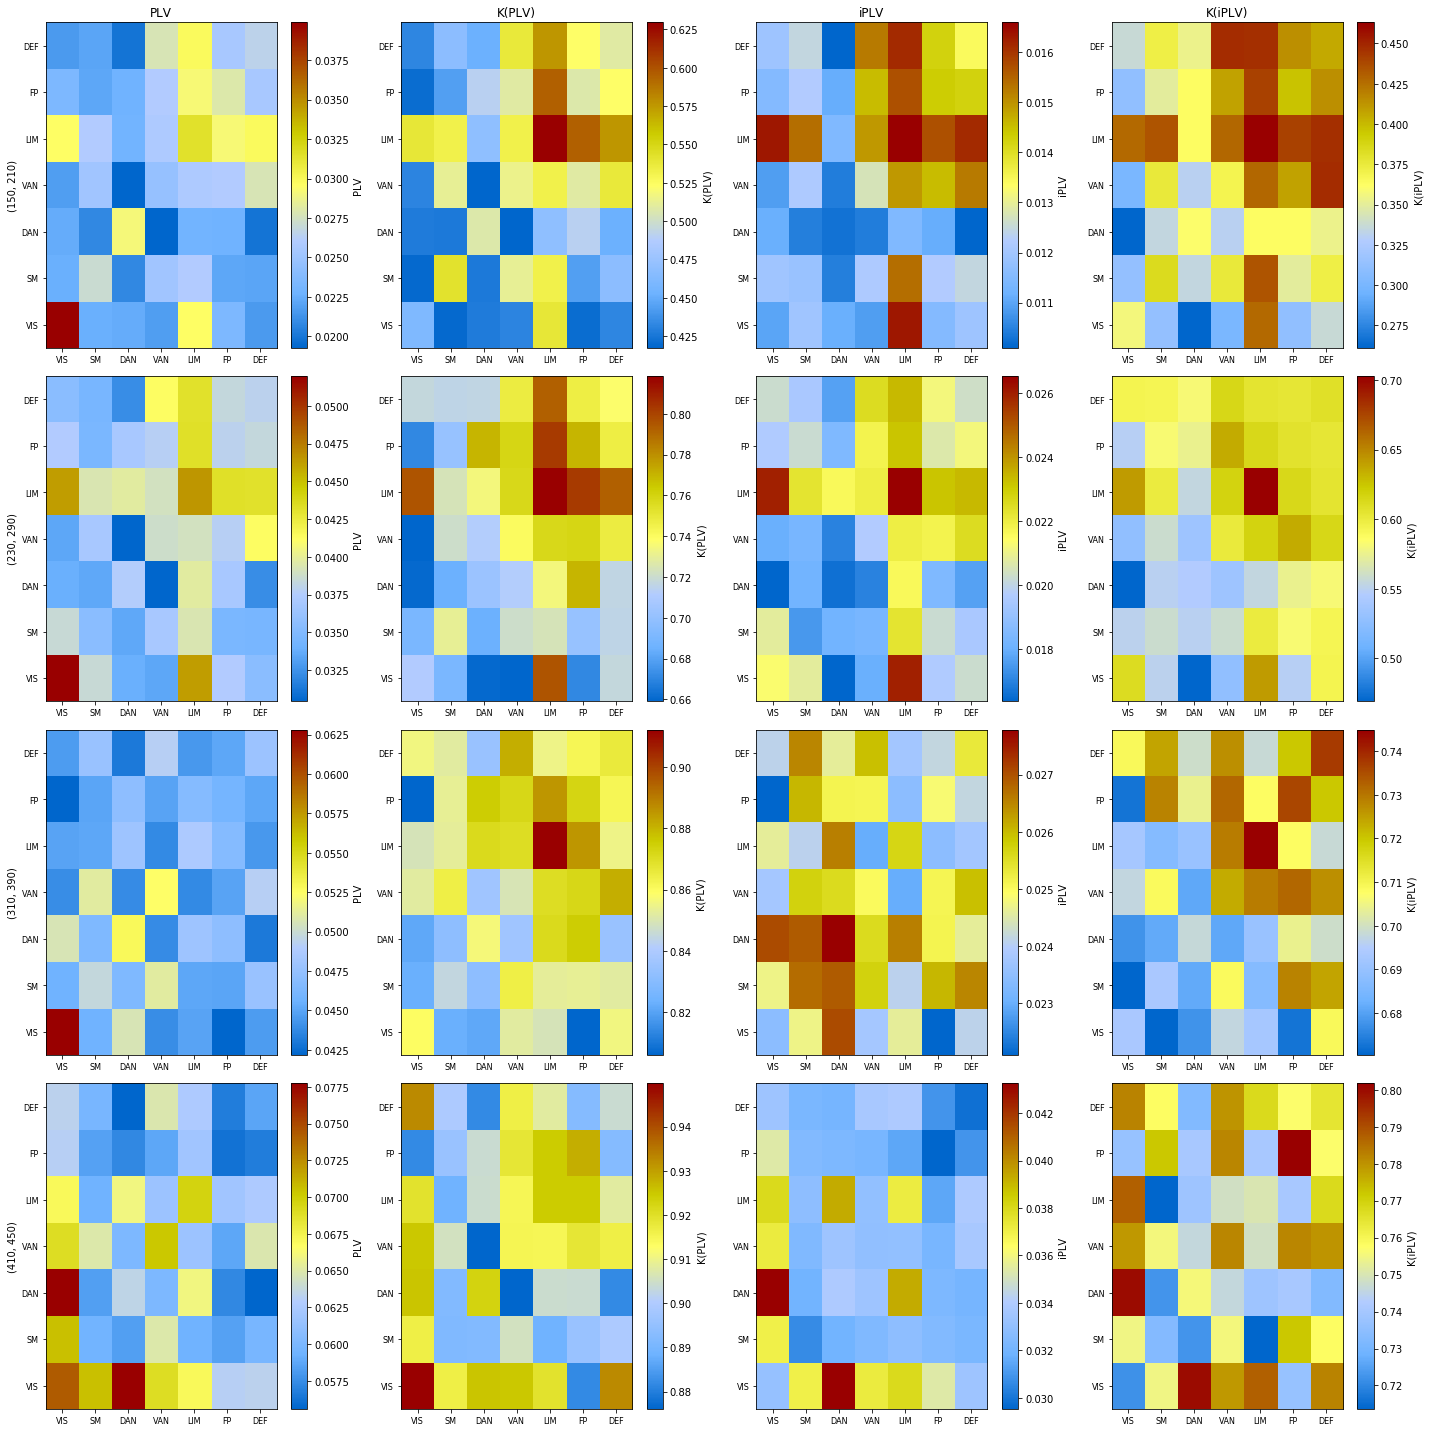

In [8]:
plv_average = np.nanmean(group_morphed_plv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subjects_clean],axis=-1)

iplv_average = np.nanmean(group_morphed_iplv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subjects_clean],axis=-1)

k_average_plv = np.nanmean(group_morphed_k_plv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subjects_clean],axis=-1)

k_average_iplv = np.nanmean(group_morphed_k_iplv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subjects_clean],axis=-1)
hemi_parcels = 7

freq_ranges = ((150,210),(230,290),(310,390),(410,450))

plv_average = np.delete(plv_average, [0, hemi_parcels+1], axis=1)
plv_average = np.delete(plv_average, [0, hemi_parcels+1], axis=2)

iplv_average = np.delete(iplv_average, [0, hemi_parcels+1], axis=1)
iplv_average = np.delete(iplv_average, [0, hemi_parcels+1], axis=2)

k_average_plv = np.delete(k_average_plv, [0, hemi_parcels+1], axis=1)
k_average_plv = np.delete(k_average_plv, [0, hemi_parcels+1], axis=2)

k_average_iplv = np.delete(k_average_iplv, [0, hemi_parcels+1], axis=1)
k_average_iplv = np.delete(k_average_iplv, [0, hemi_parcels+1], axis=2)

yeo_ticks = ['VIS', 'SM', 'DAN', 'VAN', 'LIM', 'FP', 'DEF']
titles = ('PLV','K(PLV)', 'iPLV', 'K(iPLV)')
x_labels = ('PLV','K(PLV)', 'iPLV', 'K(iPLV)')



f, axs = plot.subplots(4,4, figsize=(20,20))
for freq_range, ax in zip(freq_ranges, axs):
    
    freq_mask = np.logical_and(frequencies >= freq_range[0], frequencies <= freq_range[1] )
    
    yeo_plv = np.stack((plv_average[:,:7,:7], plv_average[:,-7:,-7:]))
    yeo_iplv = np.stack((iplv_average[:,:7,:7], iplv_average[:,-7:,-7:]))
    kk_plv = np.stack((k_average_plv[:,:7,:7], k_average_plv[:,-7:,-7:]))
    kk_iplv = np.stack((k_average_iplv[:,:7,:7], k_average_iplv[:,-7:,-7:]))
    
    yeo_plv = np.nanmean(yeo_plv[:,freq_mask,...], axis=(0,1))
    yeo_iplv = np.nanmean(yeo_iplv[:,freq_mask,...], axis=(0,1))
    kk_plv = np.nanmean(kk_plv[:,freq_mask,...], axis=(0,1))
    kk_iplv = np.nanmean(kk_iplv[:,freq_mask,...], axis=(0,1))

    im = np.ndarray((4,), dtype=object)

    im[0] = ax[0].imshow(yeo_plv, cmap=ripples_cmap, aspect='auto')
    im[1] = ax[1].imshow(kk_plv, cmap=ripples_cmap, aspect='auto')
    im[2] = ax[2].imshow(yeo_iplv, cmap=ripples_cmap, aspect='auto')
    im[3] = ax[3].imshow(kk_iplv, cmap=ripples_cmap, aspect='auto')
    
    for jdx in range(4):
        plot.colorbar(im[jdx], ax=ax[jdx]).set_label(x_labels[jdx])


for idx,ax in enumerate(axs.flatten()):
    ax.set_yticks(np.arange(0,7))
   
    ax.set_yticklabels(yeo_ticks)
    ax.set_xticks(np.arange(0,7))
    ax.set_xticklabels(yeo_ticks)
    ax.tick_params(labelsize=8)
    ax.invert_yaxis()
    
for idx,ax in enumerate(axs[0]):
    ax.set_title(titles[idx])
    
for idx, ax in enumerate(axs):
    ax[0].set_ylabel(freq_ranges[idx])
#    plot.colorbar(im[idx], ax=ax, orientation='horizontal', pad=.05).set_label(x_labels[idx])
f.tight_layout()
plot.savefig('/home/gabri/Yeo_main_panels.svg', format='svg', dpi=300)

# Split strategy using multiples splits

In [9]:
subjects_clean = cluster_subjects[cluster_subjects.subject_cluster.isin((1,2))].index
print(subjects_clean)

Int64Index([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19,
            21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 41, 42,
            43, 45, 47, 48, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 63, 64,
            66],
           dtype='int64')


In [101]:
def split_data(data, coh1_indices, coh2_indices, hemi_parcels=7):

        data_coh1 = np.nanmean(data[-18:,-cortical_parcels:, 
                                    -cortical_parcels:,
                                    coh1_indices], axis=-1)
        
        data_coh2 = np.nanmean(data[-18:,-cortical_parcels:, 
                                    -cortical_parcels:,
                                    coh2_indices], axis=-1)
        
        data_coh1 = np.delete(data_coh1, [0, hemi_parcels+1], axis=1)
        data_coh1 = np.delete(data_coh1, [0, hemi_parcels+1], axis=2)
        data_coh2 = np.delete(data_coh2, [0, hemi_parcels+1], axis=1)
        data_coh2 = np.delete(data_coh2, [0, hemi_parcels+1], axis=2)
        
        # create the full adjaceny matrix such as first dim is cohort
        # then frequency x parcel x parcel 
        data_grouped = np.stack((data_coh1, data_coh2))
        
        #data_grouped[np.isnan(data_grouped)] = 0
        
        return data_grouped
    
def filter_edges(data, coverage, hemi_mask, min_n=1):
    edge_mask = np.logical_and(coverage >= min_n, hemi_mask)
    edge_mask_final = np.logical_and(edge_mask[0], edge_mask[1])
    return data[0, edge_mask_final],data[1, edge_mask_final]


def compute_correlation(data, coverage, hemi_mask, subj_threshold):
    
    p, b = filter_edges(data, coverage, hemi_mask,min_n = subj_threshold)

    corr_splits = np.corrcoef(p,b)[0,1]
    
    return corr_splits

In [102]:
cortical_parcels = 16
hemi_parcels = 7

subject_coverage = group_edge_counts[0,-cortical_parcels:, -cortical_parcels:,:]
subject_coverage = np.delete(subject_coverage, [0, hemi_parcels+1], axis=0)
subject_coverage = np.delete(subject_coverage, [0, hemi_parcels+1], axis=1)
subject_coverage[np.isnan(subject_coverage)] = 0

# save edge coverage in separate variable
edge_coverage = subject_coverage.copy()
# no matter how many channel one subjects contributes to the overall group mean
# if he has one edge, he counts as one subject sampling that edge
subject_coverage  = np.nansum((subject_coverage > 0).astype(int), axis=-1)

# pre-alloc matrices 
plv_corr_splits = np.zeros((2, 100, 4))
iplv_corr_splits = np.zeros((2, 100, 4))
struct_corr_splits= np.zeros((2, 100, 4))

lh_mask = np.zeros((14, 14), dtype=bool)
rh_mask = np.zeros((14, 14), dtype=bool)
lr_mask = np.zeros((14, 14), dtype=bool)
lh_mask[:hemi_parcels, :hemi_parcels] = 1
rh_mask[-hemi_parcels:, -hemi_parcels:] = 1
lr_mask[:hemi_parcels, -hemi_parcels:] = 1
hemi_masks = np.stack((lh_mask, rh_mask, lr_mask))

for subj_threshold in range(1,5):
    # read splits from files
    splits = np.genfromtxt('/home/gabri/localdata/rest-bids/At_Least_%d_Subj_per_Schaefer-Edge_BestSplit.csv'%subj_threshold, delimiter=',')
    n_splits, n_subjects = splits.shape
    
    for idx_split in range(n_splits):    
        # for each splits get coh1 and coh2 subject indices
        coh1_indices = splits[idx_split,:32].astype(int)
        coh2_indices = splits[idx_split,33:].astype(int)
        
        plv_grouped = split_data(group_morphed_plv, coh1_indices, coh2_indices)
        edge_cov_grouped = split_data(group_edge_counts, coh1_indices, coh2_indices)
        iplv_grouped = split_data(group_morphed_iplv, coh1_indices, coh2_indices)

        for idx_mask in range(2):
            h = hemi_masks[idx_mask]
            
            plv_corr = compute_correlation(plv_grouped, edge_cov_grouped, h, subj_threshold)
            plv_corr_splits[idx_mask, idx_split, subj_threshold-1] = plv_corr
            
            iplv_corr = compute_correlation(iplv_grouped, edge_cov_grouped, h, subj_threshold)
            iplv_corr_splits[idx_mask, idx_split, subj_threshold-1] = iplv_corr

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


[0.82404799 0.77935563]


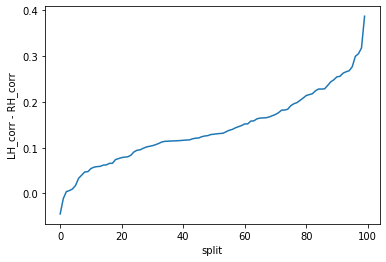

In [128]:
optimal_split = np.argmin(np.diff(plv_corr_splits[...,0],axis=0))

plot.plot(range(100), np.sort(np.diff(plv_corr_splits[...,0],axis=0)).T)
plot.xlabel('split')
plot.ylabel('LH_corr - RH_corr')
print(plv_corr_splits[:,optimal_split,0])

In [136]:
coh1_indices = splits[optimal_split,:32].astype(int)
coh2_indices = splits[optimal_split,33:].astype(int)

plv_grouped = split_data(group_morphed_plv,coh1_indices,coh2_indices)
iplv_grouped = split_data(group_morphed_k_plv,coh1_indices,coh2_indices)

plv1 = np.nanmean(np.stack((plv_grouped[0,-18:,:7,:7], plv_grouped[0,-18:,-7:,-7:])),axis=(0,1))
plv2 = np.nanmean(np.stack((plv_grouped[1,-18:,:7,:7], plv_grouped[1,-18:,-7:,-7:])),axis=(0,1))

iplv1 = np.nanmean(np.stack((iplv_grouped[0,-18:,:7,:7], iplv_grouped[0,-18:,-7:,-7:])),axis=(0,1))
iplv2 = np.nanmean(np.stack((iplv_grouped[1,-18:,:7,:7], iplv_grouped[1,-18:,-7:,-7:])),axis=(0,1))

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [137]:
def get_range(arr):
    return arr.min(), arr.max()

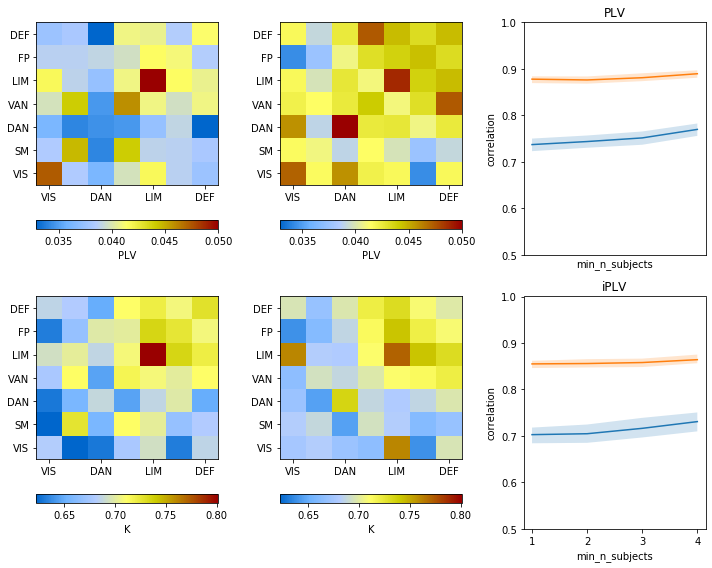

In [140]:
fig, axs = plot.subplots(2,3, figsize=(10, 8))
cmin, cmax = get_range(np.concatenate((plv1.flatten(), plv2.flatten())))


im1= axs[0][0].imshow(plv1, aspect='auto',cmap=ripples_cmap, vmin=cmin, vmax=0.05)
axs[0][0].invert_yaxis()
plot.colorbar(im1, ax=axs[0][0],  orientation='horizontal').set_label('PLV')

im2= axs[0][1].imshow(plv2, cmap=ripples_cmap, aspect='auto', vmin=cmin, vmax=0.05)
axs[0][1].invert_yaxis()
plot.colorbar(im2, ax=axs[0][1], orientation='horizontal').set_label('PLV')

yeo_ticks = ['VIS', 'SM', 'DAN', 'VAN', 'LIM', 'FP', 'DEF']
titles = ('Cov-Coh1','Cov-Coh2')
x_labels = ('PLV','PLV')

axs[0][2].plot(range(1,5), plv_corr_splits.mean(axis=1).T)
for idx in range(2):
    axs[0][2].fill_between(range(1,5), *bootstrap_ci(plv_corr_splits[idx]),alpha=.2)
axs[0][2].set_xlabel('min_n_subjects')
axs[0][2].set_title('PLV')
axs[0][2].set_xticks([])
axs[0][2].set_ylabel('correlation');
axs[0][2].set_ylim([0.5, 1])

cmin, cmax = get_range(np.concatenate((iplv1.flatten(), iplv2.flatten())))

axs[1][2].plot(range(1,5), iplv_corr_splits.mean(axis=1).T)
for idx in range(2):
    axs[1][2].fill_between(range(1,5), *bootstrap_ci(iplv_corr_splits[idx]),alpha=.2)
axs[1][2].set_xlabel('min_n_subjects')
axs[1][2].set_title('iPLV')
axs[1][2].set_ylabel('correlation');
axs[1][2].set_ylim([0.5,1])

im3= axs[1][0].imshow(iplv1, cmap=ripples_cmap, aspect='auto', vmin=cmin, vmax=cmax)
axs[1][0].invert_yaxis()
plot.colorbar(im3, ax=axs[1][0], orientation='horizontal').set_label('K')

im4= axs[1][1].imshow(iplv2, cmap=ripples_cmap, aspect='auto', vmin=cmin, vmax=cmax)
axs[1][1].invert_yaxis()
plot.colorbar(im4, ax=axs[1][1], orientation='horizontal').set_label('K')

for ax in axs[:,:2].flatten():
    ax.set_yticks(np.arange(0,7))
    ax.set_yticklabels(yeo_ticks)
    ax.set_xticks(np.arange(0,7)[::2])
    ax.set_xticklabels(yeo_ticks[::2])

fig.tight_layout()
fig.savefig('/home/gabri/split_yeo_plv_panels.svg', dpi=300)

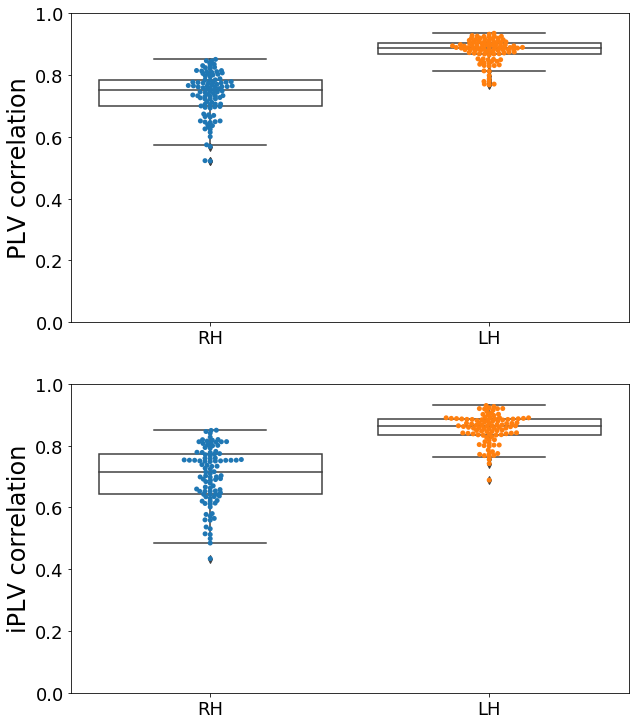

In [142]:
import seaborn as sns
fig, axes = plot.subplots(figsize=(10,12.5), nrows=2)
sns.swarmplot(data=plv_corr_splits[:2,...,0].T, ax=axes[0])
sns.boxplot(data=plv_corr_splits[:2,...,0].T, ax=axes[0])
sns.swarmplot(data=iplv_corr_splits[:2,...,0].T, ax=axes[1])
sns.boxplot(data=iplv_corr_splits[:2,...,0].T, ax=axes[1])
for box in axes[0].artists + axes[1].artists:
    box.set_facecolor('white')
for ax, label in zip(axes, ['PLV correlation', 'iPLV correlation']):
    ax.set_xticklabels(['RH', 'LH', 'Inter'])
    ax.tick_params(labelsize=18)
    ax.set_ylabel(label, fontsize=24)
    ax.set_ylim([0, 1])
fig.savefig('/home/gabri/split_yeo_plv_correlation.svg', dpi=300)

In [52]:
def filter_edges(data, coverage, hemi_mask, min_n=1):
    edge_mask = np.logical_and(coverage >= min_n, hemi_mask)
    return data[0,edge_mask[0,...]],data[1,edge_mask[1,...]]

p,b = filter_edges(plv_grouped, edge_cov_grouped, hemi_masks[0])
print(np.corrcoef(p,b))

[[1.         0.77544414]
 [0.77544414 1.        ]]


## Scratch ##

In [ ]:
# some subjects migth have been skipped for whatever reasons let's remove them from mean
subj_clean = np.nanmean(group_morphed_plv[0,...], axis=(0,1)).squeeze()
subj_clean[np.isnan(subj_clean)] = 0
#cortical_parcels = 102 #Schafer
cortical_parcels = 16 #Yeo

group_morphed_k[ group_morphed_plv == 0] = np.nan
group_edge_counts[ group_morphed_plv == 0] = np.nan
group_morphed_plv[ group_morphed_plv == 0] = np.nan
group_morphed_iplv[ group_morphed_plv == 0] = np.nan

plv_average = np.nanmean(group_morphed_plv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subj_clean > 0],axis=-1)

iplv_average = np.nanmean(group_morphed_iplv[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subj_clean > 0],axis=-1)

k_average = np.nanmean(group_morphed_k[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subj_clean > 0],axis=-1)

cov_average = np.nansum(group_edge_counts[:,-cortical_parcels:,
                                -cortical_parcels:, 
                                subj_clean > 0],axis=-1)

def prep_data_1(data):
    dd = data.copy()
    ee = np.stack((dd[:,:8,:8],dd[:,-8:,-8:]), axis=3)
    return ee

def nanmin(arr):
    return arr[~np.isnan(arr)].min()
def nanmax(arr):
    return arr[~np.isnan(arr)].max()

def get_range(arr):
    return nanmin(arr), nanmax(arr)

plv_average_1 = prep_data_1(plv_average)
k_average_1 = prep_data_1(k_average)

print(get_range(plv_average_1), get_range(k_average_1))
print(get_range(cc_plv), get_range(cc_k))


fig, (ax1,ax2) = plot.subplots(1,2, figsize=(10,5))
im1 = ax1.imshow(np.nanmean(plv_average_1[-18:,1:,1:],axis=(0,3)), aspect='auto', cmap=ripples_cmap)
im2 = ax2.imshow(np.nanmean(k_average_1[-18:,1:,1:],axis=(0,3)), aspect='auto',cmap=ripples_cmap)
ax1.invert_yaxis()
ax2.invert_yaxis()

plot.colorbar(im1,ax=ax1)
plot.colorbar(im2,ax=ax2)




hemi_parcels = 7

plv_average = np.delete(plv_average, [0, hemi_parcels+1], axis=1)
plv_average = np.delete(plv_average, [0, hemi_parcels+1], axis=2)

k_average = np.delete(k_average, [0, hemi_parcels+1], axis=1)
k_average = np.delete(k_average, [0, hemi_parcels+1], axis=2)

cov_average = np.delete(cov_average, [0, hemi_parcels+1], axis=1)
cov_average = np.delete(cov_average, [0, hemi_parcels+1], axis=2)

edge_coverage = group_edge_counts[0,-cortical_parcels:,
                                -cortical_parcels:, 
                                :]

edge_coverage = np.delete(edge_coverage, [0, hemi_parcels+1], axis=0)
edge_coverage = np.delete(edge_coverage, [0, hemi_parcels+1], axis=1)

fig, (ax1, ax2, ax3) = plot.subplots(1, 3, sharey = True, figsize=(16,7))

im1 = ax1.imshow(np.nanmean(plv_average[-18:,:hemi_parcels,:hemi_parcels],axis=0),aspect='auto', cmap=ripples_cmap)
im2 = ax2.imshow(np.nanmean(k_average[-18:,:hemi_parcels,:hemi_parcels],axis=0),aspect='auto', cmap=ripples_cmap)
im3 = ax3.imshow(cov_average[20,:hemi_parcels,:hemi_parcels],aspect='auto', cmap=ripples_cmap)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

plot.colorbar(im1, ax=ax1, orientation='horizontal').set_label('PLV')
plot.colorbar(im2, ax=ax2, orientation='horizontal').set_label('K')
plot.colorbar(im3, ax=ax3, orientation='horizontal').set_label('edge coverage')
plot.show()

max_bin = .25
bins = np.arange(0,max_bin,(max_bin)/100)
n_freqs = frequencies.shape[0]
edge_distribution = np.empty((50,2,99), dtype=float)*np.nan
n_lh_parc = 50
n_rh_parc = 50

for f in range(n_freqs):
    lh_plvs = plv_average[f,:n_lh_parc,:n_lh_parc].flatten()
    rh_plvs = plv_average[f,-n_rh_parc:,-n_rh_parc:].flatten()
    
    edge_distribution[f,0,:],_ = np.histogram(lh_plvs[~np.isnan(lh_plvs)], bins=bins, range=(0,max_bin))
    edge_distribution[f,1,:],_ = np.histogram(rh_plvs[~np.isnan(rh_plvs)], bins=bins, range=(0,max_bin))

y_ticks = ["%.2f" %x for x in frequencies[::5]]
x_ticks = ["%.2f"%x for x in bins[::25]]
edge_distribution = edge_distribution / np.tile(np.sum(edge_distribution,axis=2, keepdims=True),99)
f, (ax1,ax2) = plot.subplots(1,2,figsize=(15,8))

im1 = ax1.imshow(np.squeeze(edge_distribution[:,0,:]), cmap=ripples_cmap, aspect='auto', vmax=max_bin)

for xx in range(10):
    
    ins1 = ax1.inset_axes([0, 1-(xx+1)*(1/10), 1, 0.1])
    ins1.plot(bins[:-1], edge_distribution[(xx)*5:(xx*5)+9,0,:].mean(axis=0), 'k', lw=4)
    ins1.patch.set_alpha(0.2)
    ins1.set_xlim([bins.min(),bins.max()])
    ins1.axis('off')
    
    ins2 = ax2.inset_axes([0, 1-(xx+1)*(1/10), 1, 0.1])
    ins2.plot(bins[:-1], edge_distribution[(xx)*5:(xx*5)+9,1,:].mean(axis=0), 'k', lw=4)
    ins2.patch.set_alpha(0.2)
    ins2.set_xlim([bins.min(),bins.max()])
    ins2.axis('off')
    
im2 = ax2.imshow(np.squeeze(edge_distribution[:,1,:]), cmap=ripples_cmap, aspect='auto' , vmax=max_bin)

ax1.set_title('strength distribution for left')

ax1.set_xticks(ticks=np.arange(0,99,25))
ax1.axes.set_xticklabels(x_ticks)
ax1.set_yticks(ticks=np.arange(0,50,5))
ax1.axes.set_yticklabels(y_ticks)
ax2.set_title('strength distribution for right')
ax2.set_xticks(ticks=np.arange(0,99,25))

ax2.axes.set_xticklabels(x_ticks)
ax2.set_yticks(ticks=np.arange(0,50,5))
ax2.axes.set_yticklabels(y_ticks)
plot.colorbar(im1, ax=ax1, orientation='horizontal', pad=.07).set_label('p')
plot.colorbar(im2, ax=ax2, orientation='horizontal', pad=.07).set_label('p')
ax1.set_xlabel('PLV')
ax2.set_xlabel('PLV')

ax1.set_ylabel('Freq. [Hz]')
plot.tight_layout()

plot.show()
#f.savefig('/home/gabri/Fig_Sxx_edge_distribution_schafer100.pdf')